<a href="https://colab.research.google.com/github/Santosh-Reddy1310/E-Waste-Project/blob/main/Week_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow


In [2]:
import tensorflow as tf  # Core TensorFlow library

from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import EfficientNetV2B0  # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models

import gradio as gr  # Web interface library to deploy and test ML models

from PIL import Image  # For image file loading and basic image operations

In [3]:
testpath = r'/content/drive/MyDrive/Colab Notebooks/modified-dataset/test'
trainpath = r'/content/drive/MyDrive/Colab Notebooks/modified-dataset/train'
validpath = r'/content/drive/MyDrive/Colab Notebooks/modified-dataset/val'

In [4]:
datatrain = tf.keras.utils.image_dataset_from_directory(trainpath,shuffle = True ,image_size=(128, 128), batch_size=32,validation_split=False)

Found 2400 files belonging to 10 classes.


In [5]:
datatest = tf.keras.utils.image_dataset_from_directory(testpath,shuffle = True ,image_size=(128, 128), batch_size=32,validation_split=False)

Found 300 files belonging to 10 classes.


In [6]:
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle = True ,image_size=(128, 128), batch_size=32,validation_split=False)

Found 300 files belonging to 10 classes.


In [7]:
print(len(datatrain.class_names))

10


In [8]:
classNames = datatrain.class_names
print(classNames)

['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


Visualixe the sample data

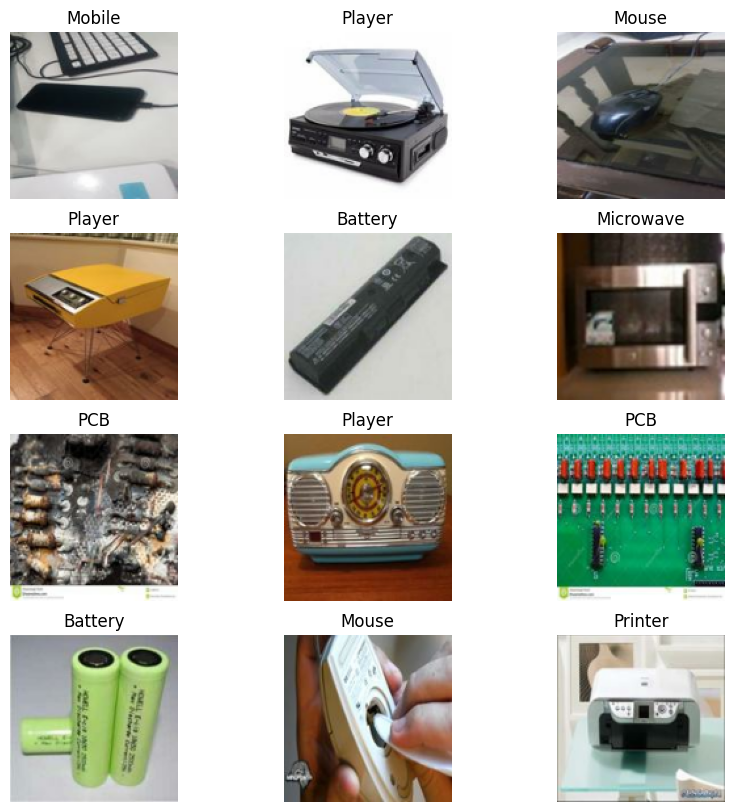

In [9]:
plt.figure(figsize=(10, 10))


#take one batch and iterate over labels and images
for images , labels in datatrain.take(1):
  #displaying first 12 images
  for i in range(12):
    ax = plt.subplot(4,3,i+1)

    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classNames[labels[i]])
    plt.axis("off")

In [10]:
def plot_class_distribution(dataset,title='Class Distribution'):
  class_counts = {}

  for images, labels in dataset:
    for label in labels.numpy():
      class_name = dataset.class_names[label]
      class_counts[class_name] = class_counts.get(class_name,0) + 1

  #prepare data for plotting
  classes = list(class_counts.keys())
  counts = list(class_counts.values())

  #create bar plot
  plt.figure(figsize=(8,5))
  plt.bar(classes,counts,color='skyblue')
  plt.xlabel('Class')
  plt.ylabel('Count')
  plt.title(title)
  plt.xticks(rotation=45)
  plt.show()

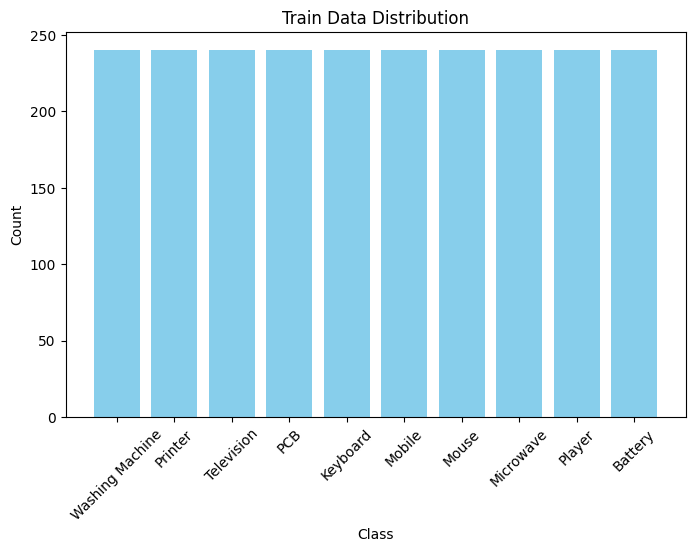

In [12]:
plot_class_distribution(datatrain,title='Train Data Distribution')

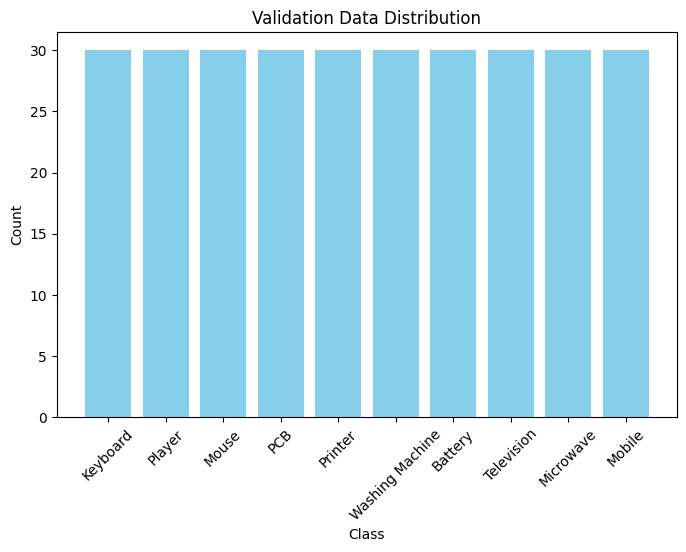

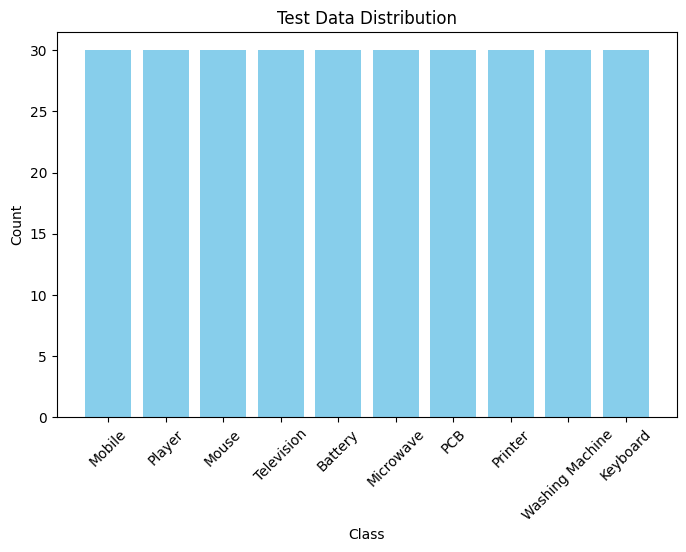

In [13]:
plot_class_distribution(datavalid,title='Validation Data Distribution')
plot_class_distribution(datatest,title='Test Data Distribution')

In [14]:
#preprocessing the data
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [15]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape = (128, 128, 3),
    include_top = False,
    weights = 'imagenet'
)


base_model.trainable = True
for layers in base_model.layers[:100]:
  layers.trainable = False


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128,128,3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0,2),
    tf.keras.layers.Dense(10,activation='softmax'),
])


model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),loss = tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['Accuracy'])

In [19]:
#define an earlystopping
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)

In [20]:
#train the model using fit() with epochs , batch_size
epochs = 5

history = model.fit(datatrain,validation_data=datavalid,epochs=epochs,batch_size=100,callbacks=[early])

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - Accuracy: 0.2848 - loss: 2.0799 - val_Accuracy: 0.8133 - val_loss: 1.0053
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - Accuracy: 0.8111 - loss: 0.9104 - val_Accuracy: 0.9200 - val_loss: 0.4520
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - Accuracy: 0.8616 - loss: 0.5174 - val_Accuracy: 0.9533 - val_loss: 0.2858
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - Accuracy: 0.9154 - loss: 0.3118 - val_Accuracy: 0.9600 - val_loss: 0.2174
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - Accuracy: 0.9434 - loss: 0.2180 - val_Accuracy: 0.9533 - val_loss: 0.1736


In [26]:
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 4, 4, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,269,040 (62.06 MB)

 Trainable params: 5,168,458 (19.72 MB)

 Non-trainable params: 763,664 (2.91 MB)

 Optimizer params: 10,336,918 (39.43 MB)

In [22]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 64, 64,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 64, 64,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 32, 32,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 32, 32,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 32, 32,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 32, 32,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 32, 32,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 32, 32,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 32, 32,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 32, 32,    │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 5,155,648 (19.67 MB)

 Non-trainable params: 763,664 (2.91 MB)

Model Performance Visualization

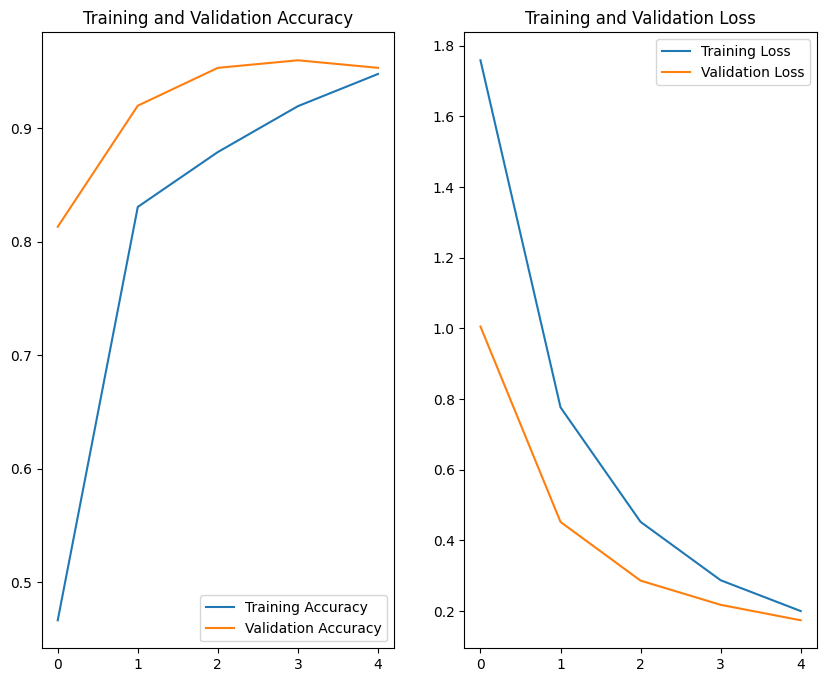

In [27]:
epochs_range = range(len(acc))

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 621ms/step - Accuracy: 0.9521 - loss: 0.1699
Test accuracy is0.9467, Test loss is 0.1762


In [30]:
### Evaluate Model Performance on Test Data using Confusion Matrix and Classification Report

# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Print confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 878ms/step
[[6 3 3 3 2 3 4 1 2 3]
 [1 3 1 4 3 2 5 3 7 1]
 [3 2 3 2 2 4 2 5 3 4]
 [2 1 1 3 7 1 5 2 6 2]
 [3 0 3 6 4 2 4 3 3 2]
 [5 3 8 1 3 3 0 2 2 3]
 [4 4 7 1 0 4 1 2 3 4]
 [4 6 2 2 3 2 4 4 2 1]
 [2 4 2 3 2 4 3 4 0 6]
 [0 4 2 5 4 7 2 3 0 3]]
              precision    recall  f1-score   support

           0       0.20      0.20      0.20        30
           1       0.10      0.10      0.10        30
           2       0.09      0.10      0.10        30
           3       0.10      0.10      0.10        30
           4       0.13      0.13      0.13        30
           5       0.09      0.10      0.10        30
           6       0.03      0.03      0.03        30
           7       0.14      0.13      0.14        30
           8       0.00      0.00      0.00        30
           9       0.10      0.10      0.10        30

    accuracy                           0.10       300
   macro avg       0.10      0.10      0.10       300
weighted avg       0.10

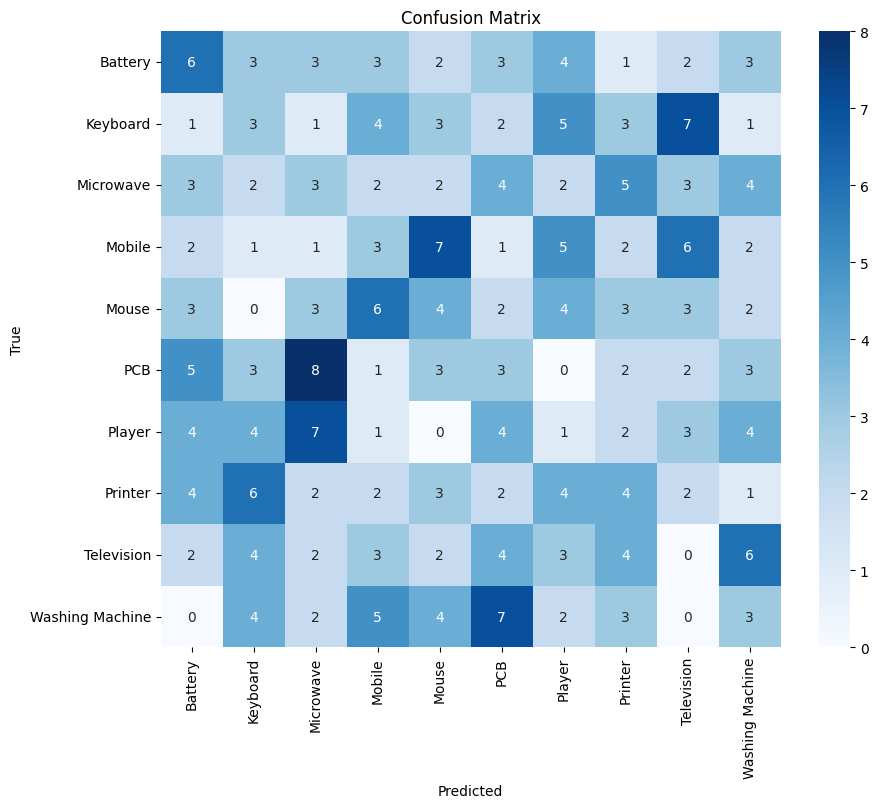

In [35]:
### Plot Confusion Matrix as Heatmap for Better Visualization

cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix
                                                     # Import seaborn for visualization

plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=classNames,
            yticklabels=classNames,
            cmap='Blues')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()                                                                # Display the plot